<a href="https://colab.research.google.com/github/lupis30puc/BERT_interpretation_with_RF/blob/main/BERT_yelp_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.9MB 7.9MB/s 
     |████████████████████████████████| 890kB 31.4MB/s 
     |████████████████████████████████| 3.2MB 52.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=fcd2e57bed144926ef9f23e362095d846a79a9acd3596b1ca4ce8fa70da3dc81
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## GPU

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Loading the tensors dataset and model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import time
import pickle

In [ ]:
with open('/content/drive/MyDrive/Yelp/model_128_/test_ids_128.pkl', 'rb') as f:
    test_ids = pickle.load(f)

with open('/content/drive/MyDrive/Yelp/model_128_/train_ids_128.pkl', 'rb') as v:
    train_ids = pickle.load(v)

In [ ]:
train_dataset = torch.load('/content/drive/MyDrive/Yelp/model_128_/_train_128')
test_dataset = torch.load('/content/drive/MyDrive/Yelp/model_128_/_test_128')

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32

train_sampler = SequentialSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

prediction_sampler = SequentialSampler(test_dataset)
prediction_dataloader = DataLoader(test_dataset, sampler=prediction_sampler, batch_size=batch_size)

### Initializing the model

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
device = torch.device("cuda")
#model = TheModelClass(*args, **kwargs)
"""
model = BertForSequenceClassification(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
"""
model = torch.load('/content/drive/MyDrive/Yelp/model_128_/tokenizer_128/model-02-FEB_3e', map_location="cuda:0")  # Choose whatever GPU device number you want
model.to(device)
# Make sure to call input = input.to(device) on any input tensors that you feed to the model


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Evaluating the validation set

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
from torch.nn import functional as F
# a function tu evaluate a model
def evaluate_model(model, dataloader, GPU_device):
  # Put model in evaluation mode
  model.eval()
  
  # Tracking variables 
  predictions, true_labels = [], []

  # Predict 
  for batch in dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits= logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
  

  loss_cross = F.cross_entropy(outputs.logits, b_labels)
  print('loss is: ' + str(loss_cross))
  print('    DONE.')
  return predictions, true_labels, loss_cross

In [ ]:
# trying out the function, it should return predictions, true labels and loss
%%time
pred_128_test, true_label_128_test, loss_128_test = evaluate_model(model, prediction_dataloader, device)

loss is: tensor(0.0111, device='cuda:0')
    DONE.
CPU times: user 10 s, sys: 9.52 s, total: 19.6 s
Wall time: 19.7 s


In [ ]:
#test
total_eval_accuracy = 0
for i in range(len(pred_128_test)):
  total_eval_accuracy += flat_accuracy(pred_128_test[i], true_label_128_test[i])
print(total_eval_accuracy)
#test
avg_val_accuracy = total_eval_accuracy / len(prediction_dataloader)
print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
#test
pred_flat = np.argmax(pred_128_test[0], axis=1).flatten()
labels_flat = true_label_128_test[0].flatten()
tot_ev_acc = np.sum(pred_flat == labels_flat) / len(labels_flat)
print(tot_ev_acc)

75.625
  Accuracy: 0.92
0.84375


In [ ]:
# trying out the function, it should return predictions, true labels and loss
%%time
pred_train, true_label_train, loss_train = evaluate_model(model, train_dataloader, device)

loss is: tensor(0.0143, device='cuda:0')
    DONE.
CPU times: user 43 s, sys: 40.7 s, total: 1min 23s
Wall time: 1min 23s


In [ ]:
total_eval_accuracy = 0
for i in range(len(pred_train)):
  total_eval_accuracy += flat_accuracy(pred_train[i], true_label_train[i])
print(total_eval_accuracy)

avg_val_accuracy = total_eval_accuracy / len(train_dataloader)
print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

pred_flat = np.argmax(pred_train[0], axis=1).flatten()
labels_flat = true_label_train[0].flatten()
tot_ev_acc = np.sum(pred_flat == labels_flat) / len(labels_flat)
print(tot_ev_acc)

## Saving logits - pred labels.
for both train and validation

In [ ]:
pred_128_test[0][:3]

array([[ 2.6976724, -2.6264153],
       [-1.8531455,  1.5775316],
       [-3.1164734,  2.8899164]], dtype=float32)

In [ ]:
# for the model 128
logits_test = [list(np.argmax(pred_128_test[p], axis=1).flatten()) for p in range(len(pred_128_test))]
print('length of the test predictions: ' + str(len(logits_test)))
# converting the list of lists into a single list
bert_test_labels = [label for l in logits_test for label in l]
print('number of predicted labels: ' + str(len(bert_test_labels)))

length of the test predictions: 82
number of predicted labels: 2599


In [ ]:
# for the model 128
logits_train = [list(np.argmax(pred_train[p], axis=1).flatten()) for p in range(len(pred_train))]
print('length of the test predictions: ' + str(len(logits_train)))
bert_train_labels = [label for l in logits_train for label in l]
print('number of predicted labels: ' + str(len(bert_train_labels)))

length of the test predictions: 325
number of predicted labels: 10394


In [ ]:
torch.save(bert_train_labels, '/content/drive/MyDrive/Yelp/model_128_/pred_labels_train')
torch.save(bert_test_labels, '/content/drive/MyDrive/Yelp/model_128_/pred_labels_test')

## Matthews Corr Coef

In [ ]:
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_label_128_test)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(pred_128_test[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_label_128_test[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


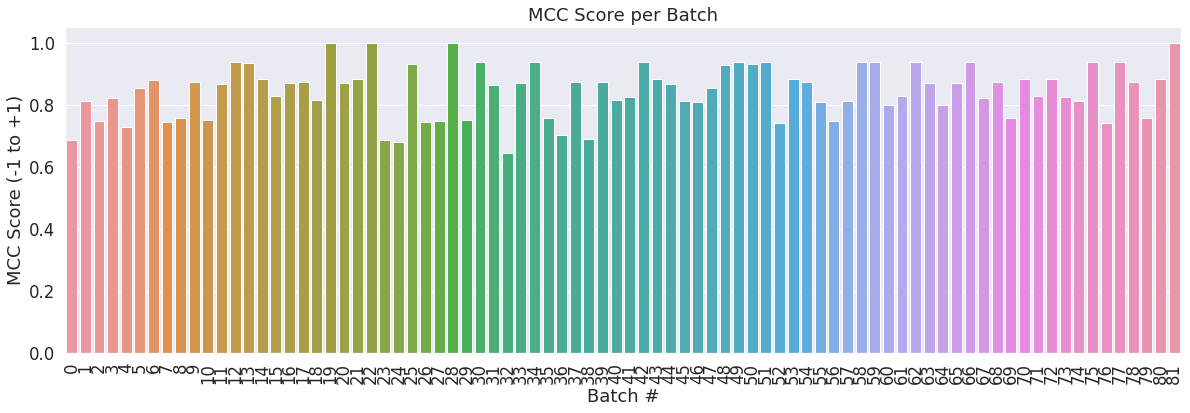

In [ ]:
# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,6)

# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')
plt.xticks(rotation=90)
# change the x axis labels so its readable

plt.show()

In [ ]:
# Combine the results across all batches. 
#flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
#flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_predictions = bert_test_labels.copy()

# Combine the correct labels for each batch into a single list.
flat_true_label = np.concatenate(true_label_128_test, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_label, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.843


# Trying with new sentences/ reviews

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/Yelp/model_128_/tokenizer_128')

In [ ]:
review_example = 'Very friendly and helpful staff. Increasing my Dutch vocabulary during commute thanks to a great suggestion.'

positive_review ='A truly inspiring venue. Friendly, helpful staff. Amazing portraits and awesome surroundings.  Hope to go back sometime soon'
#'Great set up. Very good food. Luxury Bar surroundings. Good food but quite pricey. Staff are polite & very helpful. They all look smart.'


#'Terrible customer service downstairs within the kitchen appliances department.'
negative_review = 'Completely appalled by the lack of assistance or help I received in trying to resolve an issue with an TV that has now been going on for a month. Staff appeared disinterested and unhelpful, despite me explaining I have spent in excess of five hours on hold trying to speak to someone about the resolution of the issue. There is no clarity of who to speak to, no one seems to know what is going on, and no one knows what the resolution is. I appreciate these are challenging times but I and have had no communication in any form from the company, I am the one who appears to doing all the leg work, even having to speak to the repair contractors in person to find out what is happening! Terrible service, terrible aftercare, terrible communication - would seriously advise against making any large electrical purchases from the company.'

## the real test
Remember only 2 labels: 0=negative, 1=positive

In [ ]:
def encode(sequence):
  """
  The copied version was:
    return tokenizer.encode_plus(
                sequence,
                add_special_tokens=True,
                max_length= 150,
                return_token_type_ids=False,
                padding = 'max_length',
                return_attention_mask = True,
                return_tensors = 'pt',
                truncation = True
    )
  """ 
  return tokenizer.encode_plus(sequence, return_token_type_ids=False, return_tensors = 'pt')

In [ ]:
def predict(sequence='I love you a lot. You are really great. You are wonderful and awesome.'):
    encoded = encode(sequence)
    encoded_ids = encoded['input_ids'].to(device)
    enconded_attention = encoded['attention_mask'].to(device)
    with torch.no_grad():
        output = model(encoded_ids, attention_mask=enconded_attention)[0]
        output = output.detach().cpu().numpy()
        pred_flat = np.argmax(output, axis=1).flatten()
        #sig_factor = torch.sigmoid(output) / torch.sigmoid(output).sum()
        #return {'proportional':  sig_factor.numpy().tolist(), 'sigmoid': torch.sigmoid(output).numpy().tolist(), 'stars': pred_flat.item() + 1, 'raw': output.numpy().tolist()}
        return {'label': pred_flat.item()}

In [ ]:
predict(negative_review)

{'label': 0}

# Converting input ids back to words:

In [ ]:
test_df = pd.read_pickle('/content/drive/MyDrive/Yelp/sample_test_2599.pkl')
test_df.reset_index(drop=True, inplace=True)
test_df.shape

(2599, 5)

In [ ]:
test_df.text[2]

"I walked in with my uncle one saturday to help him get his cpap machine. We met a respiratory therapist gentleman named Juan. He was very helpful, he explained why my uncle needed to use his machine, he was very knowledgeable about my uncle's condition and he was able to answer all of our questions. He showed us how the machine works, how to clean it. He was very patient with us when it came to choosing a mask, very polite and friendly. Thanks to juan he made our experience very pleasant."

In [ ]:
test_ids[2][:30]

[101,
 2939,
 4470,
 5095,
 2393,
 18133,
 9331,
 3698,
 2777,
 16464,
 19294,
 10170,
 2315,
 5348,
 14044,
 4541,
 4470,
 2734,
 2224,
 3698,
 3716,
 3085,
 4470,
 4650,
 2583,
 3437,
 3980,
 3662,
 3698,
 2573]

In [ ]:
list(tokenizer.vocab.keys())[2939]

'walked'

In [ ]:
tokenizer.decode(test_dataset[2][0])

'[CLS] walked uncle saturday help cpap machine met respiratory therapist gentleman named juan helpful explained uncle needed use machine knowledgeable uncle condition able answer questions showed machine works clean patient came choosing mask polite friendly thanks juan experience pleasant [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'